Using TensorFlow backend.


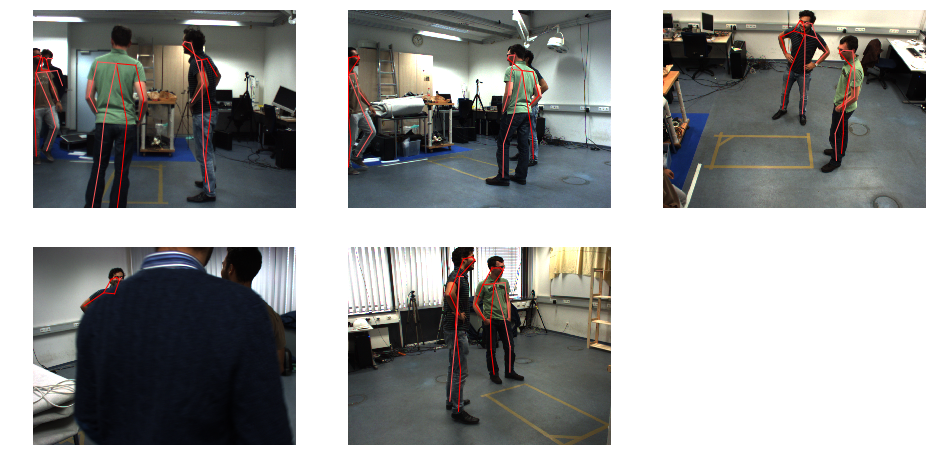

In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
sys.path.insert(0,'../debugging')
from mvpose.data import shelf
from time import time

root = join(Settings['data_root'], 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d

from openpose import OpenPose

#FRAME = 530
FRAME = 416
pe = OpenPose(tmp=tmp)
Im, Y, Calib = shelf.get(root, FRAME)
predictions = pe.predict(Im, 'cvpr_shelf', FRAME)



fig = plt.figure(figsize=(16, 8))
for idx, (im, pred) in enumerate(zip(Im, predictions)):
    ax = fig.add_subplot(2, 3, idx+1); ax.axis('off')
    ax.imshow(im)
    
    for human in pred:
        draw_mscoco_human2d(ax, human[:, 0:2], color='red')

plt.show()

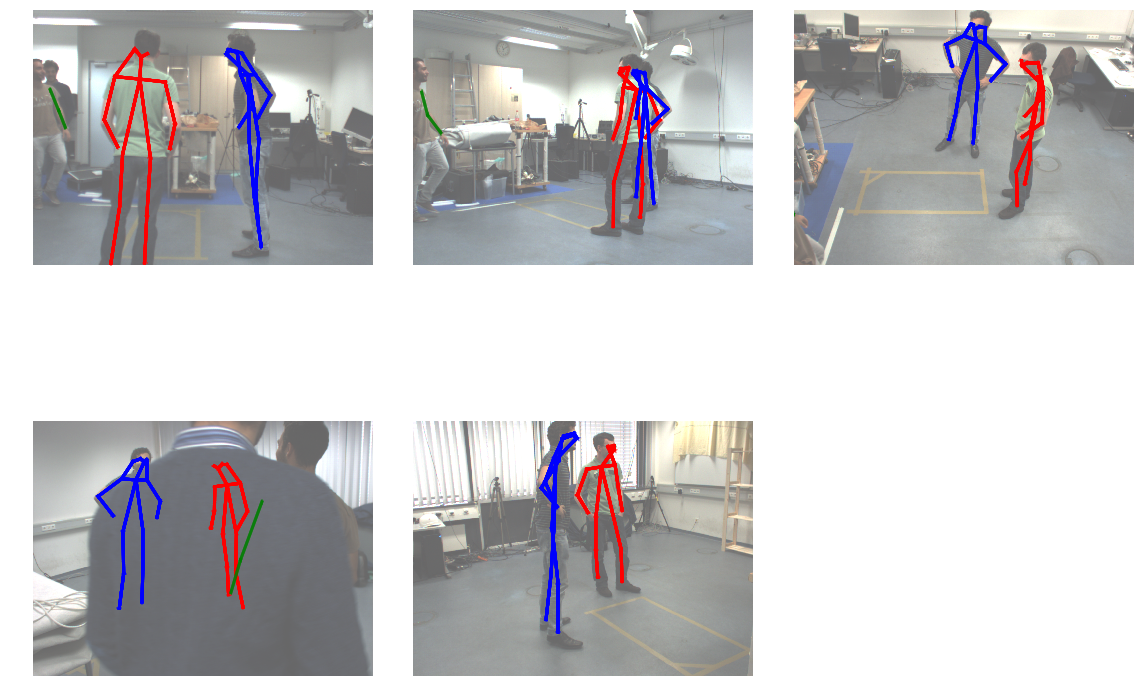

In [2]:
from mvpose.baseline.baseline import estimate

H = estimate(Calib, predictions)

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green', 'teal']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(2, 3, 1+cid)
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(H):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5,
                          color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [3]:
# =====================================================
def proper_pcp_calc(Y, Humans):
    alpha = 0.5
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs


def generate_pcp_score(frame):
    Im, Y, Calib = shelf.get(root, frame)
    predictions = pe.predict(Im, 'cvpr_shelf', frame)
    
    # -- reduce #cams
#     Calib = Calib[0:3]
#     Y = Y[0:3]
#     predictions = predictions[0:3]
    # --------------
    
    detections = estimate(Calib, predictions)
    Humans = kth.transform3d_from_mscoco(detections)
    return proper_pcp_calc(Y, Humans) 

# =====================================================

valid_frames = list(range(300, 600))
#valid_frames = list(range(300, 305))

PER_GTID = {}

for frame in valid_frames:
    _start = time()
    
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = generate_pcp_score(frame)
    if len(L_Arms) > 0:
        for gtid, larms, uarms, llegs, ulegs in zip(
            GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
        ):
            if not gtid in PER_GTID:
                PER_GTID[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID[gtid]['larms'].append(larms)
            PER_GTID[gtid]['uarms'].append(uarms)
            PER_GTID[gtid]['llegs'].append(llegs)
            PER_GTID[gtid]['ulegs'].append(ulegs)
            PER_GTID[gtid]['frame'].append(frame)
    
    
    _end = time()
    print('frame ' + str(frame) + ', elapsed:', _end - _start)

frame 300, elapsed: 0.24345135688781738
frame 301, elapsed: 0.2189333438873291
frame 302, elapsed: 0.21970081329345703
frame 303, elapsed: 0.20684003829956055
frame 304, elapsed: 0.20786476135253906
frame 305, elapsed: 0.2081928253173828
frame 306, elapsed: 0.20631623268127441
frame 307, elapsed: 0.20746278762817383
frame 308, elapsed: 0.2100212574005127
frame 309, elapsed: 0.21825909614562988
frame 310, elapsed: 0.2064666748046875
frame 311, elapsed: 0.20520615577697754
frame 312, elapsed: 0.20835137367248535
frame 313, elapsed: 0.3180727958679199
frame 314, elapsed: 0.20615363121032715
frame 315, elapsed: 0.20507073402404785
frame 316, elapsed: 0.20314764976501465
frame 317, elapsed: 0.20420050621032715
frame 318, elapsed: 0.2020127773284912
frame 319, elapsed: 0.20353984832763672
frame 320, elapsed: 0.20663905143737793
frame 321, elapsed: 0.2099609375
frame 322, elapsed: 0.2130880355834961
frame 323, elapsed: 0.22432398796081543
frame 324, elapsed: 0.21976780891418457
frame 325, ela

frame 507, elapsed: 0.3309648036956787
frame 508, elapsed: 0.32976651191711426
frame 509, elapsed: 0.5213131904602051
frame 510, elapsed: 0.34801769256591797
frame 511, elapsed: 0.3187100887298584
frame 512, elapsed: 0.41156601905822754
frame 513, elapsed: 0.39025354385375977
frame 514, elapsed: 0.40265917778015137
frame 515, elapsed: 0.41516947746276855
frame 516, elapsed: 0.3282597064971924
frame 517, elapsed: 0.3295426368713379
frame 518, elapsed: 0.30938148498535156
frame 519, elapsed: 0.2906839847564697
frame 520, elapsed: 0.2918059825897217
frame 521, elapsed: 0.30904221534729004
frame 522, elapsed: 0.3054227828979492
frame 523, elapsed: 0.3024308681488037
frame 524, elapsed: 0.2964913845062256
frame 525, elapsed: 0.3296184539794922
frame 526, elapsed: 0.30661511421203613
frame 527, elapsed: 0.40810179710388184
frame 528, elapsed: 0.300142765045166
frame 529, elapsed: 0.27493739128112793
frame 530, elapsed: 0.2784080505371094
frame 531, elapsed: 0.27960753440856934
frame 532, ela

In [4]:
total_avg = []
for key, values in PER_GTID.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

actor  0
	uarms: 0.989247311827957
	larms: 0.953405017921147
	ulegs: 1.0
	llegs: 1.0
	avg:   0.985663082437276
actor  2
	uarms: 0.9472049689440993
	larms: 0.9409937888198758
	ulegs: 1.0
	llegs: 0.9968944099378882
	avg:   0.9712732919254659
actor  1
	uarms: 0.8783783783783784
	larms: 0.44594594594594594
	ulegs: 1.0
	llegs: 1.0
	avg:   0.8310810810810811

avg*:   0.9293391518146077
